# Previsão de Vendas

Neste notebook irei apresentar algumas técnicas de machine learning aplicadas na previsão das vendas. Nossas previsões serão feitas em um conjunto de dados de uma rede de farmácias. Os dados utilizados neste trabalho podem ser acessados através do link abaixo: 

https://www.kaggle.com/c/rossmann-store-sales

Nosso objetivo será realizar a previsão de receita que o as lojas irão gerar nas seis semanas (42 dias) subsequentes ao término do período de coleta de dados. 

## 1.0 - Importação de Bibliotécas

In [28]:
# Bibliotecas para manipulação e transformação de dados
import pandas as pd
import numpy as np
from scipy.stats import randint
import datetime

# Biblioteca para transformar strings
import inflection

# Biliotecas para visualização de dados
from IPython.display import display
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Biliotecas de treinamento e avaliação de modelos de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Biblioteca para transformação de variáveis categóricas
from category_encoders import TargetEncoder

# Biblioteca para ajuste de aspectos estéticos do Notebook
import warnings

No trecho de código abaixo iremos ajustar alguns aspectos do nosso notebook:  
 - Aumentar o tamanho das colunas e linhas que serão exibidas dos DataFrames.
 - Retirar os "Warnings" que possam, por ventura, serem rtornados.

In [29]:
# Ajusta o número máximo de linhas exibidas dos DataFrames
pd.options.display.max_rows = 200
pd.options.display.max_columns = 50

# Escondendo os warnings
warnings.filterwarnings('ignore')

## 2.0 - Funções Auxiliares

In [4]:
# Função para renomear as colunas do data frame
def camel_2_snake(x):
    old_labels = x.columns
    new_labels = [inflection.underscore(i) for i in old_labels]
    x.columns = new_labels
    return x

# Função para exibir o tamanho do data frame
def data_dim (x):
    print("Número de linhas: {}\nNúmero de colunas: {}\n".format(x.shape[0], x.shape[1]))
    return None

# Função para estatísticas descritivas de dados numéricas
def stats (x):
    x = x.select_dtypes(include = "number")
    x_mean = x.mean()
    x_med = x.median()
    x_std = x.std()
    x_max = x.max()
    x_min = x.min()
    x_range = x_max - x_min
    labels = ["media", "mediana", "desv_pad", "max", "min", "range"]
    x = pd.concat([x_mean, x_med, x_std, x_max, x_min, x_range ], axis = 1)
    x.columns = labels
    
    return x

# Função para máximos e mínimos
def max_min (x):
    x = x.select_dtypes(include = "number")
    x_max = x.max()
    x_min = x.min()
    labels = ["max", "min"]
    x = pd.concat([x_max, x_min], axis = 1)
    x.columns = labels
    
    return x


# Função para grafico de correlações
def correlation_plot(x):
    x = x.select_dtypes(include = "number")
    cor_matrix = x.corr(method = "pearson")
    
    fig = plt.figure(figsize = (20,10))
    ax = fig.add_subplot()
    sns.heatmap(cor_matrix, annot = True, ax = ax)
    plt.show()
    
    return None

# Função para avaliação de modelos
def model_valuation(model, x, y, model_name):

    cv = TimeSeriesSplit(n_splits = 2)

    cv_dict = cross_validate(model, x, y, cv = cv, 
                             scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error"],
                             return_train_score = True)

    mae_mean_test = - cv_dict["test_neg_mean_absolute_error"].mean()
    mae_std_test =  cv_dict["test_neg_mean_absolute_error"].std() * 2
    mse_mean_test = - cv_dict["test_neg_mean_squared_error"].mean()
    mse_std_test =  cv_dict["test_neg_mean_squared_error"].std() * 2
    rmse_mean_test = - cv_dict["test_neg_root_mean_squared_error"].mean()
    rmse_std_test =  cv_dict["test_neg_root_mean_squared_error"].std() * 2
    score_time = cv_dict["score_time"].mean()
   
    
    mae_mean_train = - cv_dict["train_neg_mean_absolute_error"].mean()
    mae_std_train =  cv_dict["train_neg_mean_absolute_error"].std() * 2
    mse_mean_train = - cv_dict["train_neg_mean_squared_error"].mean()
    mse_std_train =  cv_dict["train_neg_mean_squared_error"].std() * 2
    rmse_mean_train = - cv_dict["train_neg_root_mean_squared_error"].mean()
    rmse_std_train =  cv_dict["train_neg_root_mean_squared_error"].std() * 2
    fit_time = cv_dict["fit_time"].mean()
    
    scores_dict = {"Model" : ["{} test score".format(model_name), "{} train score".format(model_name)],
                   "MAE": ["%2.f +/- %1.f"%(mae_mean_test,mae_std_test),"%2.f +/- %1.f"%(mae_mean_train,mae_std_train)],
                   "MSE": ["%2.f +/- %1.f"%(mse_mean_test,mse_std_test),"%2.f +/- %1.f"%(mse_mean_train,mse_std_train)],
                   "RMSE": ["%2.f +/- %1.f"%(rmse_mean_test,rmse_std_test),"%2.f +/- %1.f"%(rmse_mean_train,rmse_std_train)],
                   "Fit Time": [score_time,fit_time]}

    scores = pd.DataFrame(scores_dict, index = [0,1])

    return (cv_dict, scores)


# Função para ajuste dos hyperparâmetros
def hyp_params_tune(model, x, y, params, n_iter):
    
    #model = model()
    
    cv = TimeSeriesSplit(n_splits = 4)
    results = RandomizedSearchCV(model, param_distributions = params, n_iter = n_iter, 
                                 scoring = ["neg_mean_absolute_error", "neg_root_mean_squared_error"],
                                 cv = cv,
                                 refit = "neg_mean_absolute_error")
    results.fit(x,y)

    return results


## 3.0 - Carregamento de Dados

Os dados referentes às vendas de cada loja e as características específicas dos estabelecimentos estão separados em dois arquivos .CSV. Abaixo faremos o carregamento destes dois arquivos e juntaremos os dois em um único DataFrame.

In [5]:
# Carregando os dados
sales_df = pd.read_csv("train.csv", dtype = {"StateHoliday":str})
store_df = pd.read_csv("store.csv")

# Exibindo os dados
display(sales_df.head())
display(store_df.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# Junção dos DataFrames referentes às lojas com o DataFrame de vendas
data = pd.merge(sales_df, store_df, how = "left")

# Ajustando a nomenclatura das colunas para maior praticidade no trabalho com o conjunto de dados (para camel_2_snake ver Funções Auxiliares)
data = camel_2_snake(data)

In [7]:
# Visualizando os dados completos
data.head(8).T

,0,1,2,3,4,5,6,7
store,1,2,3,4,5,6,7,8
day_of_week,5,5,5,5,5,5,5,5
date,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31,2015-07-31
sales,5263,6064,8314,13995,4822,5651,15344,8492
customers,555,625,821,1498,559,589,1414,833
open,1,1,1,1,1,1,1,1
promo,1,1,1,1,1,1,1,1
state_holiday,0,0,0,0,0,0,0,0
school_holiday,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a


In [9]:
# Verificando o tamanho do conjunto de dados
data_dim(data)

Número de linhas: 1017209
Número de colunas: 18



In [12]:
# Salvando o progresso feito
data.to_csv("data_0.csv", sep=";", index = False)

## 4.0 - Limpeza de Dados

Nesta seção iremos ajustar os tipos dos dados presentes no nosso conjunto de dados e verificar o preenchimento e ou deleção de observações não existentes (NaNs).

In [93]:
# Carregando o DataFrame salvo na etapa anterior
df1 = pd.read_csv("data_0.csv", sep = ";")

In [94]:
# Exibindo o tipo de cada variável
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

A variável "date" está como tipo object, para que possamos trabalhar com a mesma iremos transforma-la em tipo datetime[64].

In [95]:
# Ajustando "date" para datetime
df1["date"] = pd.to_datetime(df1["date"])

Na sequência iremos buscar por variáveis que contenham valores NaNs

In [96]:
# Exibindo número de NaNs por variável
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Algumas considerações sobre o tratamento de dados faltantes:

1) Para a variável "competition_distance" os valores NaNs aparecem para as lojas que não possuem um competidor próximo. De forma a preenchermos os valores inexistentes consideraremos que os competidores destas lojas estarão, na verdade, muito distantes, algo como 10x a maior distancia encontrada para outras lojas.

2) Para as variáveis "competition_open_since_month" e "competition_open_since_year" iremos preencher com o mesmo mês e ano da variável date. Nosso objetivo com isso é poder extratir em etapas mais a frente o tempo que se passou entre a abertura das lojas e a data do faturamento presente em nosso conjunto de dados.

3) O procedimento acima será aplicado também às variáveis "promo2_since_week" e "promo2_since_year"

4) Para a variável "promo_interval" os valroes inexistentes são para as lojas que não participam das promoções e para estes casos iremso preenche-los com a string "no promotion interval"

In [100]:
# Mostrando as maiores e menores distâncias para os comeptidores
print("A maior distância de um competidor é",df1["competition_distance"].max())
print("A maior distância de um competidor é",df1["competition_distance"].min(), end = "\n\n")

# Exibindo quais lojas não possuem competidores próximos
display(df1[df1["competition_distance"].isna()].drop_duplicates(subset = ["store"]))

# Preenchendo NaNs da variável "competition_distance" com 10x a distancia máxima encontrada na variável original
df1["competition_distance"].fillna(value = 10*75860, inplace = True )

A maior distância de um competidor é 75860.0
A maior distância de um competidor é 20.0



,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
290,291,5,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,5,2015-07-31,6306,540,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,5,2015-07-31,6000,466,1,1,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [19]:
# Preenchendo NaNs da variável "competition_open_since_month" com o mês referente aquela observação e mudando a variavél
# para int
df1["competition_open_since_month"] = df1.apply(lambda x: x["date"].month 
                                                          if pd.isna(x["competition_open_since_month"]) 
                                                          else x["competition_open_since_month"], axis = 1)

df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)



# Preenchendo NaNs da variável "competition_open_since_year" com o ano referente aquela observação e mudando a variavél
# para int
df1["competition_open_since_year"] = df1.apply(lambda x: x["date"].year 
                                                         if pd.isna(x["competition_open_since_year"]) 
                                                         else x["competition_open_since_year"], axis = 1)

df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)


# Preenchendo NaNs da variável "promo2_since_year" com o ano referente aquela observação e mudando a variavél
# para int
df1["promo2_since_year"] = df1[["date", "promo2_since_year"]].apply(lambda x: x["date"].year 
                                                                               if pd.isna(x["promo2_since_year"])
                                                                               else x["promo2_since_year"], axis = 1)

df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)


# Preenchendo NaNs da variável "promo2_since_week" com o ano referente aquela observação e mudando a variavél
# para int
df1["promo2_since_week"] = df1[["date", "promo2_since_week"]].apply(lambda x: x["date"].week 
                                                                               if pd.isna(x["promo2_since_week"])
                                                                               else x["promo2_since_week"], axis = 1)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)

# Preenchendo os valores inexistentes da variável "promo_interval" com a string "no promotion interval"
df1["promo_interval"].fillna("no promotion interval", inplace = True)

Após as mudanças feitas nos códigos acima iremos verificar novamente o dataframe para confirmarmos se o nosso tratamento de dados funcionou.

In [20]:
df1.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

Perfeito! Não há mais dados faltantes em nosso conjunto de dados e, portanto, poderemos seguir para a próxima etapa do nosso projeto.

In [21]:
# Salvando o progresso feito no conjunto de dados
df1.to_csv("data_1.csv", sep=";", index = False)

## 5.0 - Criação de Novas Variáveis

Na seção abaixo tentaremos extrair mais informações do banco de dados existente através da criação de novas variáveis. Deixo indicado abaixo as variáveis que serão criadas:

1) "competition_time": tempo decorrido entre a observação presente no conjunto de dados e a data na qual foi aberto o competidor.

2) "promo2_time": tempo decorrido entre a data da observação presente no conjunto de dados e a entrada de determinada loja na promoção extendida, promo2.

3) "date_day": dia do mês de determinada observação retirada da variável "date".

4) "date_month": mês de determinada observação retirada da variável "date".

5) "date_year": ano de determinada observação retirada da variável "date".

6) "date_week": nº da semana de determinada observação dentro do ano

7) "is_promo2_month": meses em que ocorre a promoção extendida para determinada loja.

Obs: algumas variáveis auxiliares também serão criadas para permitir que possamos derivar as variáveis acima, contudo estas serão deletadas em passos futuros.

In [28]:
# Carregando o DataFrame salvo na etapa anterior
df2 = pd.read_csv("data_1.csv", sep=";",parse_dates = ["date"])

In [29]:
# Separando a variável "date" em dia, mês e ano
df2["date_day"] = df2["date"].dt.day
df2["date_month"] = df2["date"].dt.month
df2["date_year"] = df2["date"].dt.year
df2["date_week"] = df2["date"].dt.isocalendar().week

# Incluindo variável para medir quanto tempo desde a abertura da concorrencia
df2["competition_date"] = df2.apply(lambda x: pd.Timestamp(x["competition_open_since_year"],
                                                           x["competition_open_since_month"],
                                                           1), axis = 1)

# Calculando os dias entre a abertura do concorrente e o dia em questão
df2["competition_time"] = (df2["date"] - df2["competition_date"]).dt.days

# Quando a loja do concorrente foi aberta após o período de coleta dos dados a variável competition_time ficará negativa. Como 
# não há sentido em termos datas nevativas iremos transformar todas estas observações em zero.
df2["competition_time"] = df2.apply(lambda x: 0 if x["competition_time"] < 0 else x["competition_time"], axis = 1)

In [30]:
# Incluindo variável para medir quanto tempo desde a abertura da concorrencia
df2["promo2_date"] = df2.apply(lambda x: datetime.datetime.strptime(str(x["promo2_since_year"]) + "-" + 
                                                              str(x["promo2_since_week"]) + "-" + 
                                                              "0", "%Y-%W-%w" ) - datetime.timedelta(days = 7), axis = 1)

# Calculando os dias entre a abertura do concorrente e o dia em questão
df2["promo2_time"] = (df2["date"] - df2["promo2_date"]).dt.days

# Quando a loja do concorrente foi aberta após o período de coleta dos dados a variável competition_time ficará negativa. Como 
# não há sentido em termos datas negativas iremos transformar todas estas observações em zero.
df2["promo2_time"] = df2.apply(lambda x: 0 if x["promo2_time"] < 0 else x["promo2_time"], axis = 1)

In [31]:
# Incluindo variável para indicar que no mês em questão haverá promoção extendida
month_names = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}
df2["is_promo2_month"] = df2.apply(lambda x: 1 if month_names[x["date_month"]] in x["promo_interval"] else 0, axis = 1)

In [32]:
df2.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [40]:
# Salvando o progresso feito no conjunto de dados
df2.to_csv("data_2.csv", sep=";", index = False)

## 5.0 - Estatísticas Descritivas

Na secção abaixo iremos apresentar algumas estatísticas do nosso banco de dados de forma a nos ajudar na busca por informações de interesse durante as próximas etapas deste trabalho

A função stats, disponível na seção Funções Auxiliares, apresenta as estatísticas descritivas de todas as variáveis numéricas do DataFrame. Observar que para algumas variáveis não faz sentido analisarmos a média, mediana e desvio padrão como é o caso das variáveis "store", "open", "promo", "date_", entre outras, para estas variáveis iremos aplicar a função max_min que apresenta apenas o máximo e o mínimo das variáveis do banco de dados. Com estas informações é possível identificarmos outliers ou valores indevidos.

A aplicação dos widgets de seleção de variáveis são para melhorar a organização e facilitar a exploração de dados

In [33]:
# Cria a caixa para seleção interativa de variáveis
num_col = df2.select_dtypes(include = "number").columns
multi_selector = widgets.SelectMultiple(options=list(num_col.values),
                                        value=list(num_col.values),
                                        description='Variáveis:',
                                        disabled=False,
                                        style = {"description_width": "initial"})

# Função que aplica o valor selecionado no widget no banco de dados e chama a função stats
def update_stats (df, w1):  
    df = df.loc[:,w1]
    display(stats(df))

# Exibe interativamente a caixa de seleção e a tabela retornada pela função stats
widgets.interactive(update_stats, df = widgets.fixed(df2), w1 = multi_selector)

interactive(children=(SelectMultiple(description='Variáveis:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

In [34]:
# Cria a caixa para seleção interativa de variáveis
num_col = df2.select_dtypes(include = "number").columns
multi_selector = widgets.SelectMultiple(options=list(num_col.values),
                                        value=list(num_col.values),
                                        description='Variáveis:',
                                        disabled=False,
                                        style = {"description_width": "initial"})

# Função que aplica o valor selecionado no widget no banco de dados e chama a função max_min
def update_max_min (df, w1):   
    df = df.loc[:,w1]
    display(max_min(df))

# Exibe interativamente a caixa de seleção e a tabela retornada pela função max_min
widgets.interactive(update_max_min, df = widgets.fixed(df2), w1 = multi_selector)

interactive(children=(SelectMultiple(description='Variáveis:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

A partir da análise das tabelas identificamos o outlier presente na variável "competition_open_since_year", que possui como valor mínimo o ano de 1900. Vamos verificar mais de perto esse outlier para definirmos uma estratégia para correção do mesmo.

In [35]:
# Verifica a qual loja está associado o outlier na variável competiton_open_since_year
outlier = df2.query("competition_open_since_year == 1900")["store"].drop_duplicates().iloc[0]
print("A loja com variável 'competition_opne_since_year' == 1900 é: %d"%outlier)

A loja com variável 'competition_opne_since_year' == 1900 é: 815


É possível observar que o ano de abertura 1900 está sendo utilizado apenas para a loja 815, sendo assim iremos assumir que o houve um erro de digitação neste valor, para subistituição do mesmo utilizaremos o ano de 1990 que está dentro do range de anos das demais observações do nosso conjunto de dados.

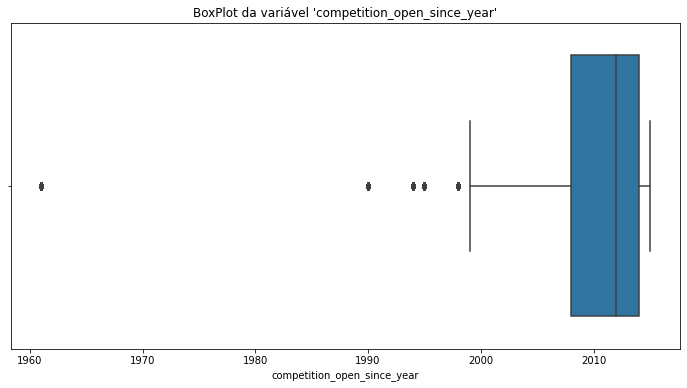

In [36]:
# BoxPlot da variável "competition_open_since_year"
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot()
sns.boxplot(x = "competition_open_since_year", data = df2.query("competition_open_since_year > 1900"), ax = ax)
ax.set_title("BoxPlot da variável 'competition_open_since_year'")
plt.show()

In [39]:
# Corrigindo o outlier na variável "competition_open_since_year"
df2["competition_open_since_year"] = df2.apply(lambda x: 1990 if x["competition_open_since_year"] == 1900 
                                                              else x["competition_open_since_year"], axis = 1)
print("Novo mínimo: {}".format(df2["competition_open_since_year"].min()))

Novo mínimo: 1961


Abaixo podemos verificamos as correlações entre as variáveis presentes no banco de dados

In [38]:
# Cria a caixa para seleção interativa de variáveis
num_col = df2.select_dtypes(include = "number").columns
multi_selector = widgets.SelectMultiple(options=list(num_col.values),
                                        value=list(num_col.values),
                                        description='Selecione as variáveis:',
                                        disabled=False)

# Função que aplica o valor selecionado no widget no banco de dados e chama a função correlation_plot
def update_corr (df, w1):   
    df = df.loc[:,w1]
    correlation_plot(df)
    return None

# Exibe interativamente a caixa de seleção e a tabela retornada pela função max_min
widgets.interactive(update_corr, df = widgets.fixed(df2), w1 = multi_selector)

interactive(children=(SelectMultiple(description='Selecione as variáveis:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, …

In [ ]:
# Salvando o progresso feito no conjunto de dados
df2.to_csv("data_2.csv", sep=";", index = False)

## 6.0 - Análise Exploratória

Nesta seção estamos interessados em identificar padrões no nosso banco de dados e informações que possam trazer insights para o entendimento do problema que estamos trabalhando

In [41]:
# Carregando o DataFrame salvo na etapa anterior
df3 = pd.read_csv("data_2.csv", sep=";",parse_dates = ["date"])

In [42]:
# Ajustando alguns parâmetros de visualização de dados da bibilioteca Seaborn
sns.set_theme(context='notebook', style='darkgrid', palette='deep')

Primeiramente vamos verificar o comportamento das vendas com os tipos de lojas. Em nosso banco de dados temos duas váriáveis que determinam características específicas de cada loja, são elas: "assortment" e "store_type". Vamos verificar primeiramente a distribuição das lojas nas categorias de cada uma destas variáveis.

In [43]:
aux = pd.crosstab(index = store_df["Assortment"], columns = store_df["StoreType"], 
            margins = True, margins_name = "Total", normalize = True).round(3)*100

aux1 = pd.crosstab(index = store_df["Assortment"], columns = store_df["StoreType"], 
            margins = True, margins_name = "Total")

display(aux)
display(aux1)

StoreType,a,b,c,d,Total
Assortment,,,,,
a,34.2,0.6,6.9,11.5,53.2
b,0.0,0.8,0.0,0.0,0.8
c,19.8,0.1,6.4,19.7,46.0
Total,54.0,1.5,13.3,31.2,100.0


StoreType,a,b,c,d,Total
Assortment,,,,,
a,381,7,77,128,593
b,0,9,0,0,9
c,221,1,71,220,513
Total,602,17,148,348,1115


É possível perceber que a maior parte das lojas são do tipo "a", cerca de 54%, seguidas das lojas "d", "c", e "b". Para os tipos de sortimentos temos que os tipos a e c são os mais comuns, já o tipo b aparece em apenas 0.8% do total de lojas, sendo utilizado unicamente nas lojas de tipo b.

Vamos verificar agora o faturamento de cada tipo de loja

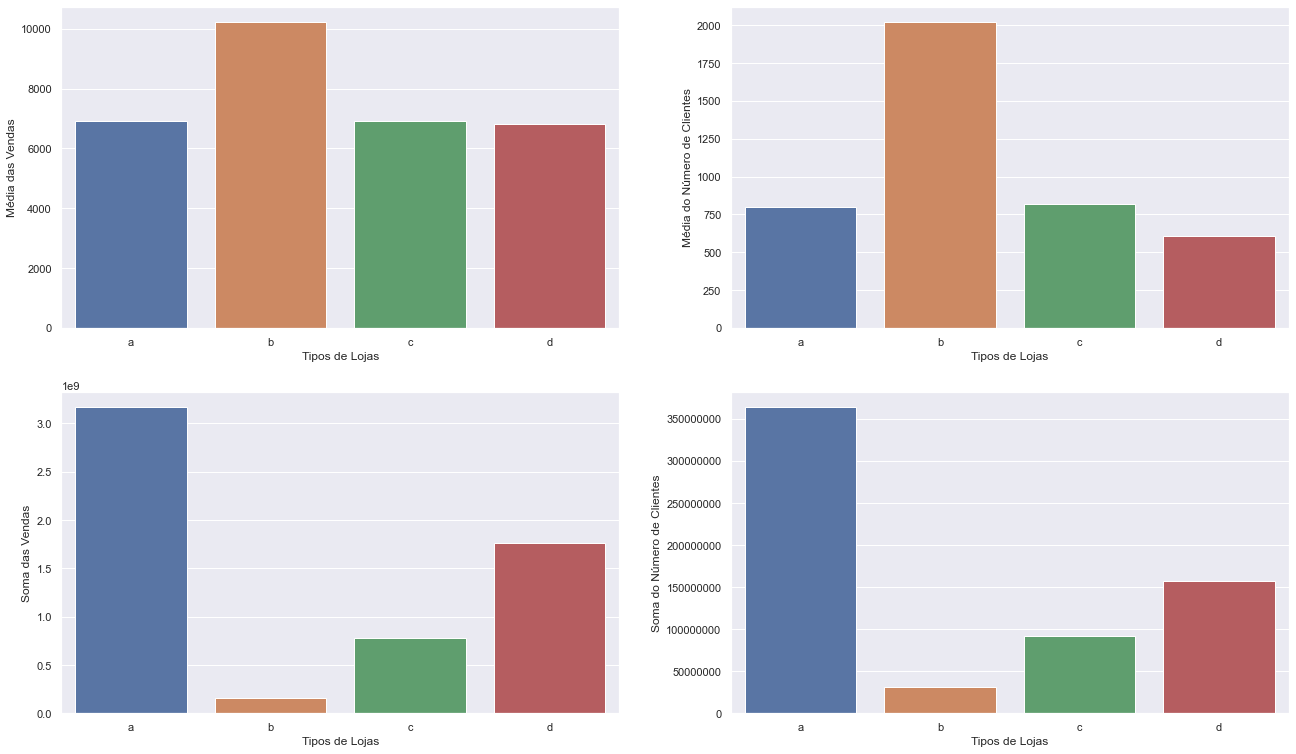

In [44]:
aux = df3.query("open == 1").groupby(by = "store_type").mean().reset_index()
aux1 = df3.query("open == 1").groupby(by = "store_type").sum().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (22,13))
specs = plt.GridSpec(nrows = 2, ncols = 2)
ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[0,1])
ax3 = fig.add_subplot(specs[1,0])
ax4 = fig.add_subplot(specs[1,1])
sns.barplot(x = "store_type", y = "sales", data = aux, ax = ax1)
sns.barplot(x = "store_type", y = "customers", data = aux, ax = ax2)
sns.barplot(x = "store_type", y = "sales", data = aux1, ax = ax3)
sns.barplot(x = "store_type", y = "customers", data = aux1, ax = ax4)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Tipos de Lojas")
ax1.set_ylabel("Média das Vendas")

ax2.set_xlabel("Tipos de Lojas")
ax2.set_ylabel("Média do Número de Clientes")

ax3.set_xlabel("Tipos de Lojas")
ax3.set_ylabel("Soma das Vendas")

ax4.set_xlabel("Tipos de Lojas")
ax4.set_ylabel("Soma do Número de Clientes")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

É possível verificar que a loja do tipo b possui média de vendas e cliente por dia muito maior que o das demais lojas, contudo se olharmos para as vendas totais as lojas do tipo a saem ganhando tendo em vista que existe uma quantidade maior de lojas deste tipo.

Na sequência vamos verificar o comportamento das vendas segundo as variáveis temporais. Abaixo apresentamos a média de valores vendidos por dia do mês dentro do período onde os dados foram coletados. Importante ressaltar que, para não termos uma distorção nas médias calculadas, estamos verificando apenas os dias nos quais as lojas estavam abertas.

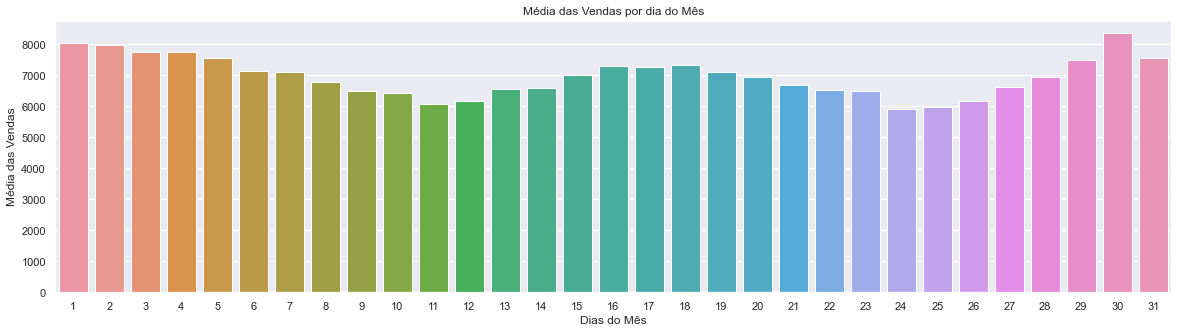

In [45]:
aux = df3.query("open == 1").groupby(by = "date_day").mean().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot()
sns.barplot(x = "date_day", y = "sales", data = aux, ax = ax1)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Dias do Mês")
ax1.set_ylabel("Média das Vendas")
ax1.set_title("Média das Vendas por dia do Mês")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

É possível perceber que nos primeiros e últimos dias do mês estão as maiores concentrações de vendas. Há também um período durante os dias 16 a 18 onde há um pico de vendas.

No gráfico abaixo apresentamos a média de vendas por mês.

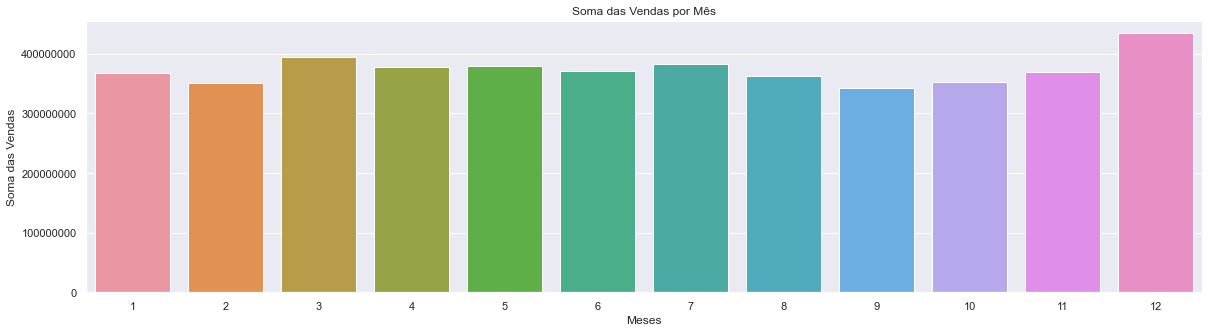

In [46]:
aux = df3.query("open == 1 & date_year < 2015").groupby(by = "date_month").sum().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot()
sns.barplot(x = "date_month", y = "sales", data = aux, ax = ax1)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Meses")
ax1.set_ylabel("Soma das Vendas")
ax1.set_title("Soma das Vendas por Mês")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Observamos que os meses com as melhores vendas são os meses de Novembro e Dezembro, que são meses onde geralmente temos recessos escolares e feriados de fim de ano. Vamos verificar também se há alteração das vendas durante os períodos de férias escolares e feriados nacionais.

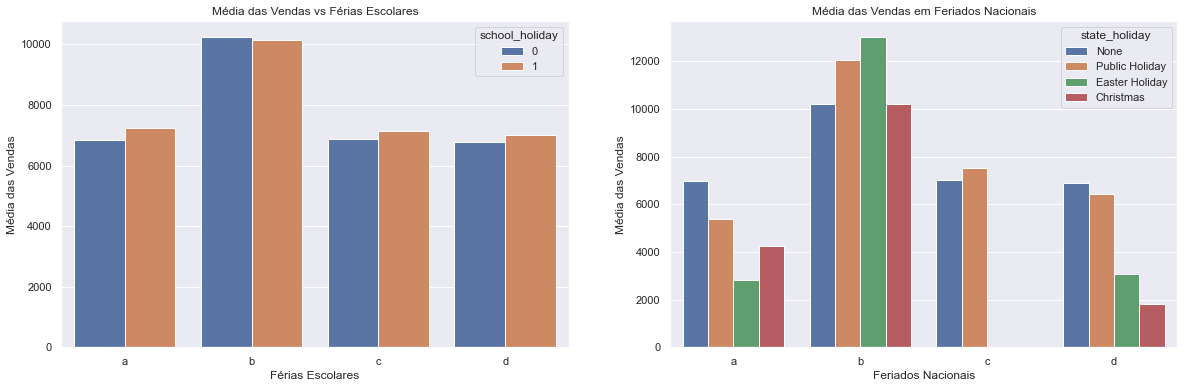

In [47]:
aux = df3.query("open == 1").groupby(by = ["store_type", "school_holiday"]).mean().reset_index()
holidays = {"0":"None", "a":"Public Holiday", "b":"Easter Holiday", "c":"Christmas"}
aux1 = df3.query("open == 1").groupby(by = ["store_type", "state_holiday"]).mean().reset_index()
aux1["state_holiday"] = aux1["state_holiday"].map(holidays)


# Gerando o gráfico
fig = plt.figure(figsize = (20,6))
specs = plt.GridSpec(nrows = 1, ncols = 2)
ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[0,1])

sns.barplot(x = "store_type", y = "sales", hue = "school_holiday", data = aux, ax = ax1)
sns.barplot(x = "store_type", y = "sales", hue = "state_holiday", data = aux1, ax = ax2)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Férias Escolares")
ax1.set_ylabel("Média das Vendas")
ax1.set_title("Média das Vendas vs Férias Escolares")

ax2.set_xlabel("Feriados Nacionais")
ax2.set_ylabel("Média das Vendas")
ax2.set_title("Média das Vendas em Feriados Nacionais")


plt.ticklabel_format(style='plain', axis='y')
plt.show()

Como o faturamento dos tipode diferentes de lojas podem variar enormemente fizemos a verificação das receitas extratificadas por tipos de loja e por feriados. Observa-se que o faturamento médio das lojas a e d é menor durante períodos de recesso coletivo, já o faturamento das lojas b e c aumentou durante os períodos de férias.  

Vamos verificar agora o comportamento das vendas durante os dias da semana para verificarmos se há algum padrão específico.

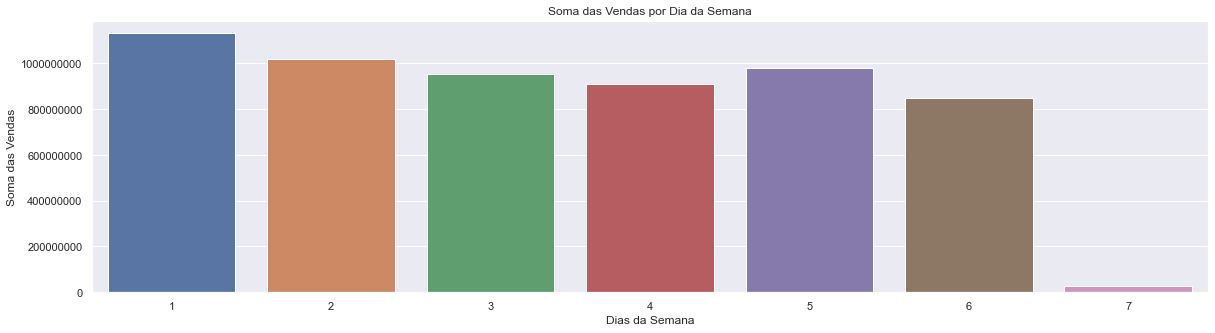

In [48]:
aux = df3.query("open == 1").groupby(by = "day_of_week").sum().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot()
sns.barplot(x = "day_of_week", y = "sales", data = aux, ax = ax1)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Dias da Semana")
ax1.set_ylabel("Soma das Vendas")
ax1.set_title("Soma das Vendas por Dia da Semana")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Verificando as vendas durante os dias de semana percebemos que aos finais de semana as vendas tendem a ser mais baixas, de certo modo isso entra em contradição com as demais análises, haja vista que, para alguns tipos de lojas dias onde geralmente os clientes estão de folga do trabalho (feriados) há um aumento das vendas. Vamos explorar as médias de vendads para ter uma visão melhor do fenômeno.

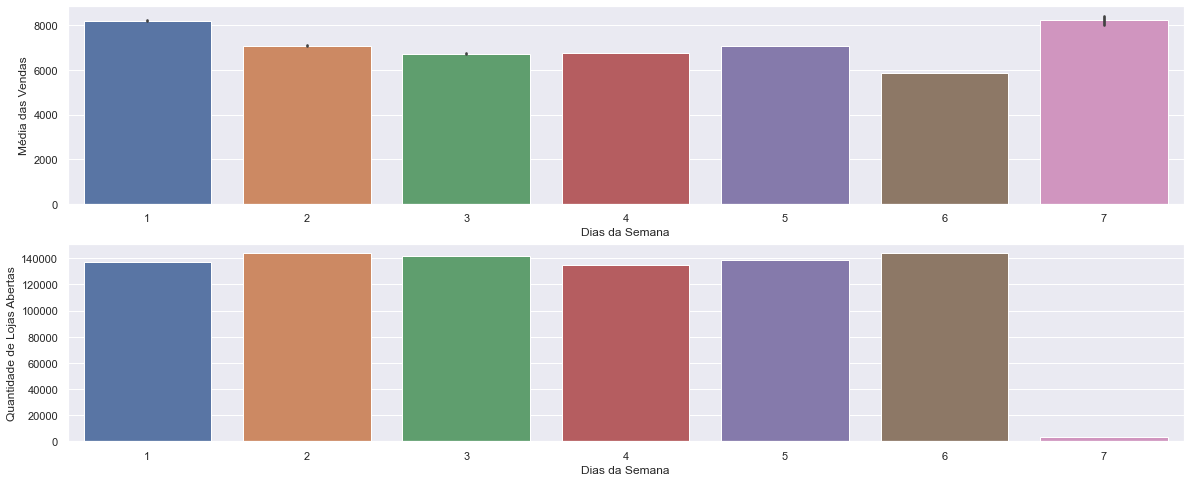

In [49]:
aux = df3.query("open == 1")
aux1 = df3.groupby(by = "day_of_week").sum().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,8))
specs = plt.GridSpec(nrows = 2, ncols = 1)
ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[1,0])
sns.barplot(x = "day_of_week", y = "sales", data = aux, ax = ax1)
sns.barplot(x = "day_of_week", y = "open", data = aux1, ax = ax2)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Dias da Semana")
ax1.set_ylabel("Média das Vendas")

ax2.set_xlabel("Dias da Semana")
ax2.set_ylabel("Quantidade de Lojas Abertas")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

É possível verificar que no domingo a maior parte das lojas encontram-se fechadas, por isso há uma diminuição nas vendas quando olhamos para a soma acumulada, contudo se verificarmos a média das vendas no domingo percebemos que os valores médios são maiores que as médias dos demais dias. Abaixo vamos analisar mais de perto este fenômeno:

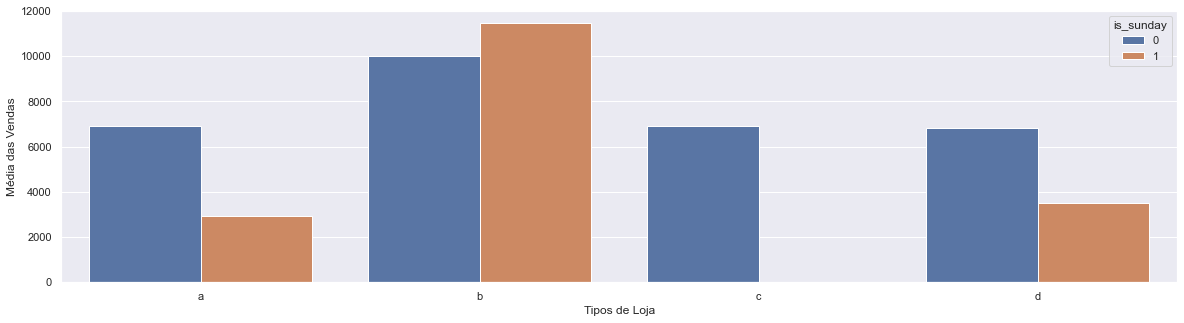

In [50]:
aux = df3.query("open == 1").copy()
aux["is_sunday"] = aux.apply(lambda x: 1 if x["day_of_week"]==7 else 0, axis = 1)
aux = aux.groupby(["store_type", "is_sunday"]).mean().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot()
sns.barplot(x = "store_type", y = "sales", hue = "is_sunday", data = aux, ax = ax1)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Tipos de Loja")
ax1.set_ylabel("Média das Vendas")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Nos gráficos acima percebe-se que o comportamento de vendas durante o domingo pode variar dependendo do tipo de loja. Para as Lojas a e d o faturamento durante o final de semana é menor, já para a loja b o faturamento é maior. Para a loja c não foi possível identificar o faturamento já que nenhuma unidade deste tipo de loja abre aos Domingos. Contudo é valido traçarmos um paralelo dos gráficos apresentados acima com os gráficos de faturamento durante o período de férias, nos recessos nacionais observou-se um aumento das das vendas na loja c o que pode indicar que, caso as lojas do tipo c abram durante os finais de semana, poderá se ter um faturamento melhor.

Na sequência iremos verificar o comportamento do faturamento tendo em vista a presença de concorrentes

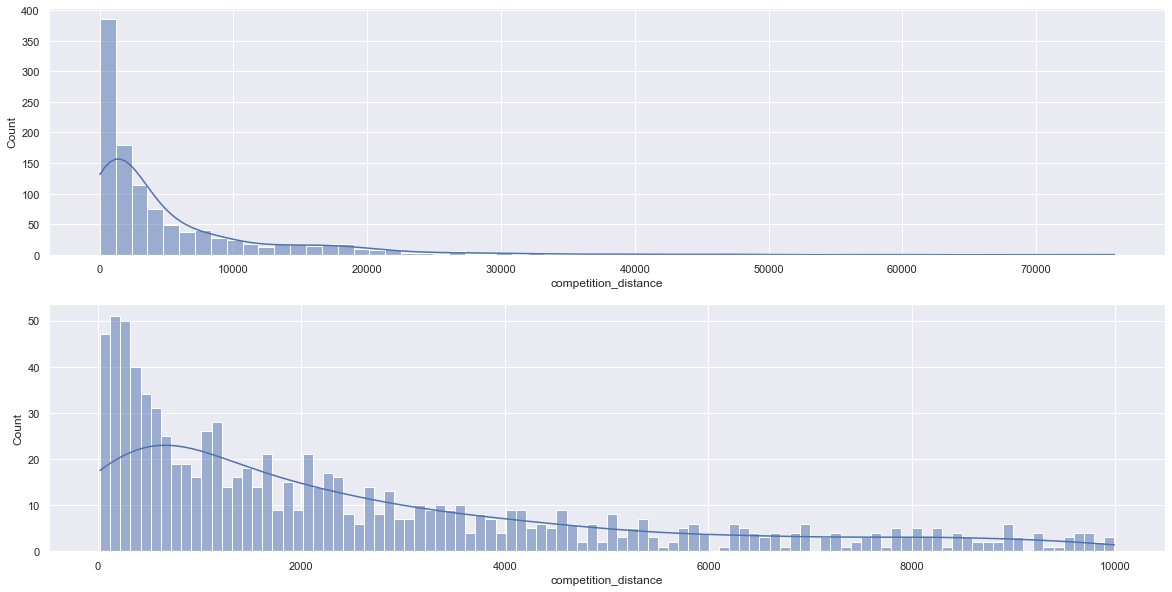

In [51]:
aux = df3.drop_duplicates("store").query("competition_distance < 100000")
aux1 = df3.drop_duplicates("store").query("competition_distance < 10000")

# Gerando o gráfico
fig = plt.figure(figsize = (20,10))
specs = plt.GridSpec(nrows = 2, ncols = 1)
ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[1,0])
sns.histplot(x = "competition_distance", data = aux, kde = True, ax = ax1)
sns.histplot(x = "competition_distance", data = aux1, kde = True, bins = 100, ax = ax2)

plt.show()

A partir dos histogramas acima podemos verificar melhor a distribuição das lojas nos ranges de distâncias presentes na variável "competition_distance". Vamos verificar abaixo o faturamento das lojas com base nas distâncias dos competidores.

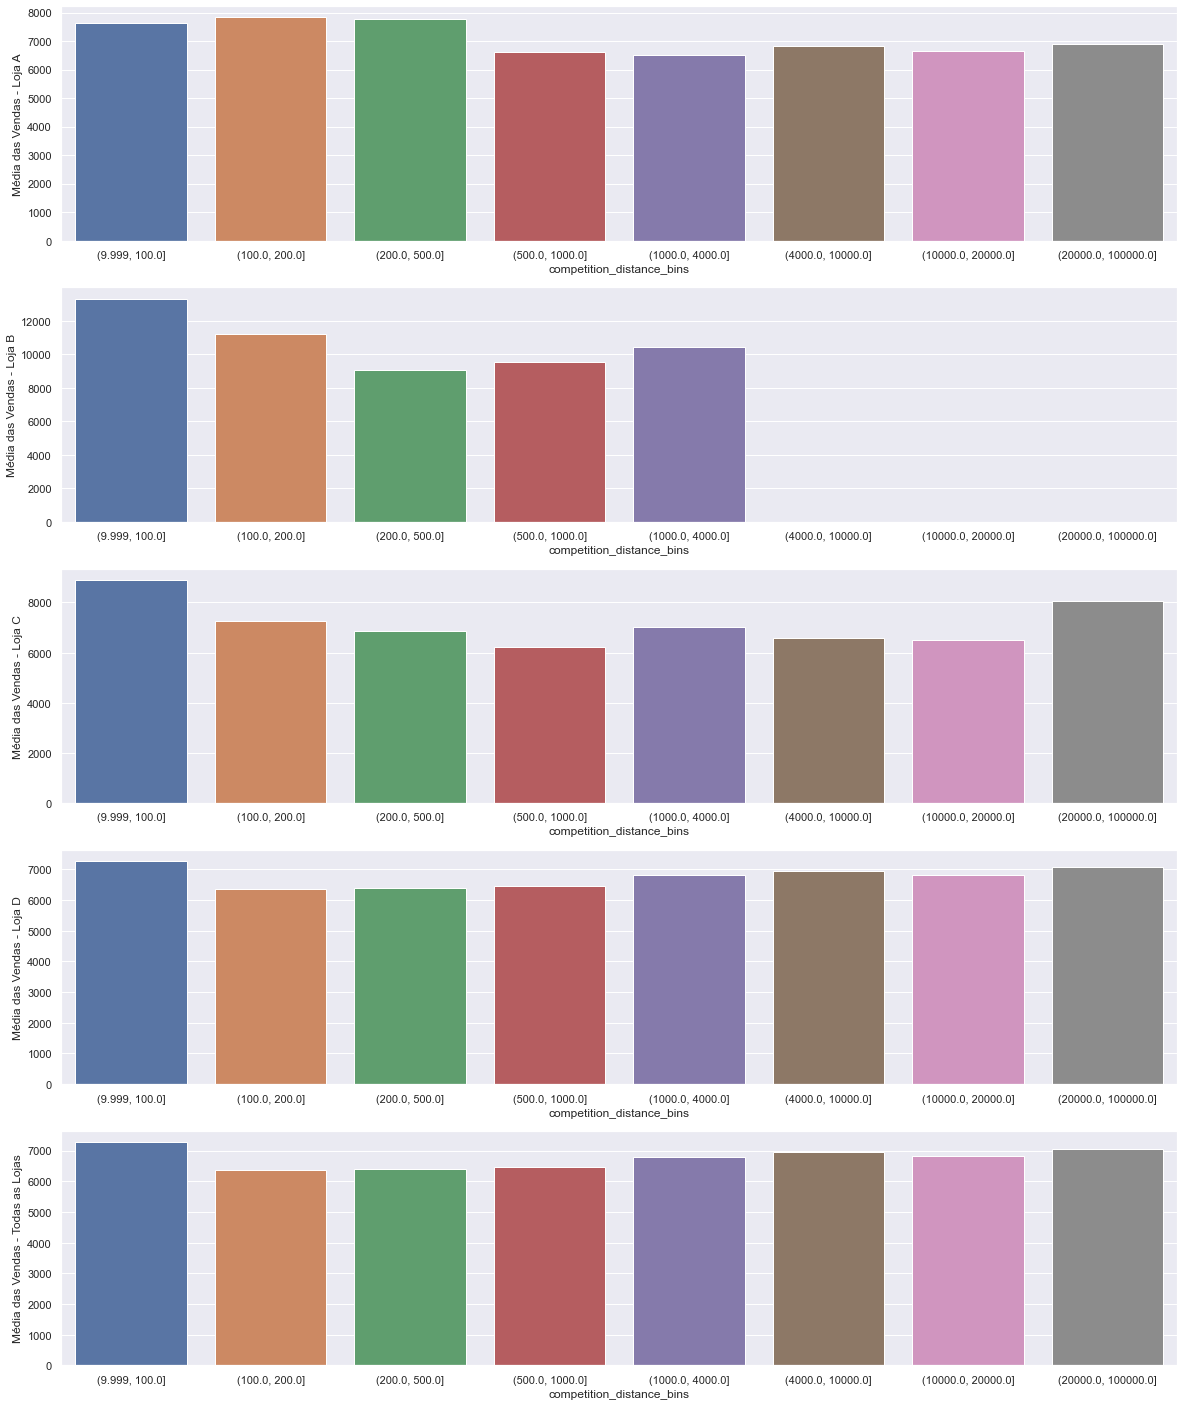

In [52]:
aux = df3.query("open == 1").copy()
aux["competition_distance_bins"] = pd.cut(aux["competition_distance"], 
                                          bins = [10,100,200,500,1000,4000,10000,20000,100000], include_lowest = True)
aux1 = aux.groupby(by = ["store_type", "competition_distance_bins"]).mean().reset_index().query("store_type == 'a'")
aux2 = aux.groupby(by = ["store_type", "competition_distance_bins"]).mean().reset_index().query("store_type == 'b'")
aux3 = aux.groupby(by = ["store_type", "competition_distance_bins"]).mean().reset_index().query("store_type == 'c'")
aux4 = aux.groupby(by = ["store_type", "competition_distance_bins"]).mean().reset_index().query("store_type == 'd'")
aux5 = aux.groupby(by = "competition_distance_bins").mean().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,25))
specs = plt.GridSpec(nrows = 5, ncols = 1)
ax1 = fig.add_subplot(specs[0,0])
ax2 = fig.add_subplot(specs[1,0])
ax3 = fig.add_subplot(specs[2,0])
ax4 = fig.add_subplot(specs[3,0])
ax5 = fig.add_subplot(specs[4,0])
sns.barplot(x = "competition_distance_bins", y = "sales", data = aux1, ax = ax1)
sns.barplot(x = "competition_distance_bins", y = "sales", data = aux2, ax = ax2)
sns.barplot(x = "competition_distance_bins", y = "sales", data = aux3, ax = ax3)
sns.barplot(x = "competition_distance_bins", y = "sales", data = aux4, ax = ax4)
sns.barplot(x = "competition_distance_bins", y = "sales", data = aux4, ax = ax5)

# Ajustando alguns parâmetros do Gráfico
ax1.set_ylabel("Média das Vendas - Loja A")
ax2.set_ylabel("Média das Vendas - Loja B")
ax3.set_ylabel("Média das Vendas - Loja C")
ax4.set_ylabel("Média das Vendas - Loja D")
ax5.set_ylabel("Média das Vendas - Todas as Lojas")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Com base nos gráficos acima é possível perceber que para as lojas b, c e d o faturamento médio aumenta com a proximidade do cliente já para as lojas a encontramos as distâncias mais favoráveis como sendo entre 100 a 500 metros dos concorrentes.

Na sequência vamos identificar a influência da realização de promoções no nosso banco de dados

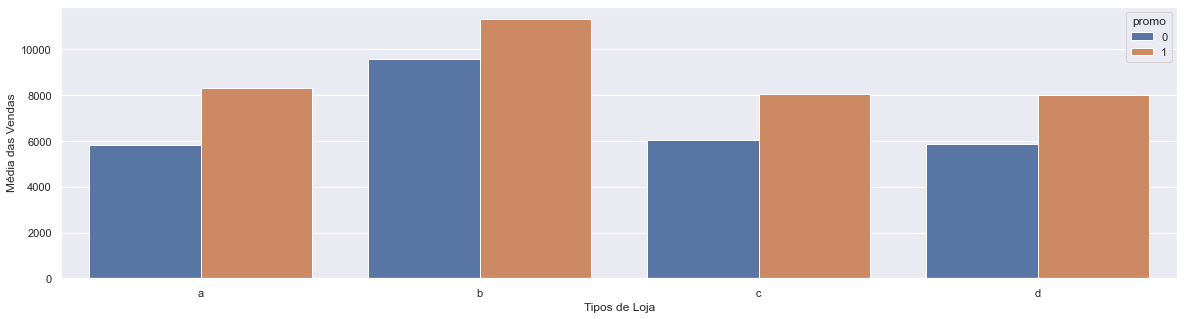

In [53]:
aux = df3.query("open == 1").groupby(by = ["store_type", "promo"]).mean().reset_index()

# Gerando o gráfico
fig = plt.figure(figsize = (20,5))
ax1 = fig.add_subplot()
sns.barplot(x = "store_type", y = "sales", hue = "promo", data = aux, ax = ax1)

# Ajustando alguns parâmetros do Gráfico
ax1.set_xlabel("Tipos de Loja")
ax1.set_ylabel("Média das Vendas")

plt.ticklabel_format(style='plain', axis='y')
plt.show()

Percebe-se que a realização de promoções tem um impacto positivo nas vendas de todos os tipos de lojas

## 7.0 - Preaparação dos Dados

Nesta seção iremos realizar algumas preparações nos dados para podermos rodar nossos modelos de Machine Learning, sendo elas:

1) Retirar da base de dados os dias em que as lojas estavam fechadas. Como não há faturamento para lojas fechadas podemos sempre prever 0.

2) Retirar as Variáveis que não irão entrar nos nossos modelos.

3) Realizar a dummização de variáveis categóricas ("day_of_week", "state_holiday", "school_holiday", "store_type", "assortment").

4) Aplicar a transformação TargetEncoding na feature "store".

5) Separar nosso conjunto de dados em treino e teste.

In [30]:
# Carregando o DataFrame salvo na etapa anterior
df4 = pd.read_csv("data_2.csv", sep=";",parse_dates = ["date"])

In [31]:
# Removendo do DataFrame as observações nas quais as lojas estavam fechadas
df4 = df4[df4["open"] == 1].copy()

In [32]:
# Dumizando as variáveis categóricas
df4 = pd.get_dummies(df4, columns = ["day_of_week", "state_holiday", "school_holiday", "store_type", "assortment"], drop_first = True)

In [105]:
# Dvidindo a base de dados entre treino e teste
df4["delta_date"] = (pd.Timestamp("2015-06-19") - df4["date"]).dt.days
df_train = df4[df4["delta_date"] >= 42].copy()
print("Dimensão da Base de Treino:",df_train.shape)


df4["delta_date"] = (pd.Timestamp("2015-06-19") - df4["date"]).dt.days
df_test = df4[df4["delta_date"] < 42].copy()
print("Dimensão da Base de Teste:",df_test.shape)

Dimensão da Base de Treino: (766637, 39)
Dimensão da Base de Teste: (77755, 39)


In [34]:
# Retirando algumas variáveis que não entrarão no modelo
df_train.drop(columns = ["date", "customers", "competition_open_since_month", "competition_open_since_year",
                         "promo2", "promo2_since_week", "promo2_since_year", "promo_interval", "competition_date",
                         "competition_time", "promo2_date", "promo2_time", "is_promo2_month", "delta_date"], inplace = True)
df_test.drop(columns = ["date", "customers", "competition_open_since_month", "competition_open_since_year",
                         "promo2", "promo2_since_week", "promo2_since_year", "promo_interval", "competition_date",
                         "competition_time", "promo2_date", "promo2_time", "is_promo2_month", "delta_date"], inplace = True)

In [36]:
# Separando a base de dados de treinamento entre variáveis preditoras e variável dependente
x, y = df_train.drop(columns = ["sales"]), df_train["sales"]

## 8.0 - Modelagem 

Iniciaremos abaixo a aplicação de modelos de machine learning na modelagem dos dados. Os modelos que serão utilizados são os seguintes:

1) Regressão Linear

2) Deciosion Trees

3) Random Forest

4) XGBoost

Iremos rodar os modelos nas configurações defaut e então selecionaremos o modelo que tiver melhor desempenho para realizarmos o fine tuning dos hyperparâmetros. As métricas escolhidas para a seleção dos modelos são:

1) Erro médio absoluto

2) Raiz quadrada do erro quadrático médio 

3) Tempo de treinamento (apesar de não ser uma métrica de desempenho do modelo estamos interessados em modelos que sejam computacionalmente ageis para que possamos fazer a seleção dos hyperparametros).

### 8.1 - Regressão Linear

In [13]:
cat_transform = ColumnTransformer(transformers = [('cat_transform', TargetEncoder(), 
                                                   ["day_of_week", "state_holiday", "school_holiday", "store_type", "assortment"])],
                                 remainder = "passthrough")
model = Pipeline(steps = [("cat_transform", cat_transform),
                          ("lin_reg", LinearRegression())])
results_lr, scores_lr = model_valuation(model, x, y, "LinearRegression")
scores_lr

,Model,MAE,MSE,RMSE,Fit Time
0,LinearRegression test score,1382 +/- 46,4191583 +/- 244715,2047 +/- 60,0.416498
1,LinearRegression train score,1356 +/- 29,4034438 +/- 182848,2008 +/- 46,2.617819


### 8.2 - Decision Trees

In [231]:
cat_transform = ColumnTransformer(transformers = [('cat_transform', TargetEncoder(), 
                                                   ["day_of_week", "state_holiday", "school_holiday", "store_type", "assortment"])],
                                  remainder = "passthrough")
model = Pipeline(steps = [("cat_transform", cat_transform),
                          ("Dec_tree", DecisionTreeRegressor(random_state = 0))])
results_lr, scores_lr = model_valuation(model, x, y, "DecisionTree")
scores_lr

,Model,MAE,MSE,RMSE,Fit Time
0,DecisionTree test score,1066 +/- 264,4614542 +/- 3250106,2113 +/- 769,0.570983
1,DecisionTree train score,-0 +/- 0,-0 +/- 0,-0 +/- 0,16.634150


### 8.3 - Random Forest

In [233]:
cat_transform = ColumnTransformer(transformers = [('cat_transform', TargetEncoder(), 
                                                   ["day_of_week", "state_holiday", "school_holiday", "store_type", "assortment"])],
                                  remainder = "passthrough")
model = Pipeline(steps = [("cat_transform", cat_transform),
                          ("Rand_For", RandomForestRegressor(random_state = 0, max_depth = 10))])
results_lr, scores_lr = model_valuation(model, x, y, "RandomForest")
scores_lr

,Model,MAE,MSE,RMSE,Fit Time
0,RandomForest test score,1130 +/- 60,3061560 +/- 359752,1749 +/- 103,2.751494
1,RandomForest train score,1071 +/- 49,2741441 +/- 230870,1655 +/- 70,456.874544


### 8.4 XGBoost

In [ ]:
xgb.XGBRegressor(n_estimators = 800, max_depth = 10, learning_rate = 0.4,
                         min_child_weight = 1,)

In [234]:
cat_transform = ColumnTransformer(transformers = [('cat_transform', TargetEncoder(), 
                                                   ["day_of_week", "state_holiday", "school_holiday", "store_type", "assortment"])],
                                  remainder = "passthrough")
model = Pipeline(steps = [("cat_transform", cat_transform),
                          ("XGB", xgb.XGBRegressor(random_state = 0, n_jobs = -1))])
results_lr, scores_lr = model_valuation(model, x, y, "XGBRegressor")
scores_lr

,Model,MAE,MSE,RMSE,Fit Time
0,XGBRegressor test score,769 +/- 21,1525241 +/- 17035,1235 +/- 7,0.686999
1,XGBRegressor train score,641 +/- 41,1079685 +/- 139493,1039 +/- 67,37.054899


Avaliando os modelos gerados verificamos que os modelos ensenble (Random Forest e XGBoost) tiveram melhor desempenho no conjunto de dados. Apesar do Random Forest ter alcançado um valor de erro menor no conjunto de teste o tempo para o treinamento deste modelo se mostrou muito elevado, já o modelo XGBoost tambem teve um bom desempenho mas este modelo possui um adicional que é o tempo de aprendizado que foi muito menor que o da Random Forest. Sendo assim iremos optar por utilizar o XGBoost na nossa proxima etapa.

## 9.0 - Ajuste de Hiperparâmtros 

Na seção abaixo iremos fazer os ajustes dos Hiperparâmetros do nosso modelo. A busca pelos melhores parâmetros a serem utilizadas será feita através da técnica de Random Search onde o algorítimo irá testar combinações aleatórias de um conjunto predefinido de parâmetros.

In [248]:
np.random.seed(0)

params = {
    "XGB__n_estimators" : [500, 800, 1000, 1500, 1800, 2000, 2500],
    "XGB__learning_rate" : [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.4, 0.8],
    "XGB__max_depth" : [2, 4, 8, 10, 12],
    "XGB__min_child_weight" : [1, 2, 3, 5, 8, 13],
    "XGB__n_jobs": [-1]}    

cat_transform = ColumnTransformer(transformers = [('cat_transform', TargetEncoder(), 
                                                   ["day_of_week", "state_holiday", "school_holiday", "store_type", "assortment"])],
                                  remainder = "passthrough")
model = Pipeline(steps = [("cat_transform", cat_transform),
                          ("XGB", xgb.XGBRegressor())])


result = hyp_params_tune(model, x, y, params = params, n_iter = 15)


KeyboardInterrupt



In [39]:
cat_transform = ColumnTransformer(transformers = [('cat_transform', TargetEncoder(), 
                                                   ["store"])],
                                  remainder = "passthrough")
model = Pipeline(steps = [("cat_transform", cat_transform),
                          ("XGB", xgb.XGBRegressor(n_estimators = 2000, max_depth = 10, learning_rate = 0.08,
                         min_child_weight = 2, random_state = 0, n_jobs = -1))])
results_lr, scores_lr = model_valuation(model, x, y, "XGBRegressor")
scores_lr

Pipeline(steps=[('cat_transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transform',
                                                  TargetEncoder(),
                                                  ['store'])])),
                ('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.08,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=2, missing=nan,
                              monotone_constraints='()', n_estimators=2000,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_stat

In [ ]:
# Realizando o treinamento do modelo em toda a base de treino
model.fit(x, y)

## 10.0 - Análise do Erro

Na seção abaixo irei apresentar os resultados do modelo treinado em nossa base de dados de treino

In [101]:
# Ajustando alguns parâmetros de visualização de dados da bibilioteca Seaborn
sns.set_theme(context='notebook', style='darkgrid', palette='deep')

In [48]:
# Separando a base de dados de teste para verificação do desempenho do algoritmo
x, y = df_test.drop(columns = ["sales"]), df_test["sales"]

In [113]:
predictions = model.predict(x)

df_test["predictions"] = predictions
mae = mean_absolute_error(y, predictions)
print("MAE do modelo no banco de dados de teste: %.2f"%mae)

MAE do modelo no banco de dados de teste: 685.44


Veja que o resultado do nosso modelo no banco de dados de teste é bastante satisfatório, o erro médio está inclusive menor que o erro observado durante o processo de
cross validation da base de dados de treino.  
Abaixo iremos apresentar o MAE por loja para identificarmos se em algum conjunto específico de lojas o desempenho do modelo está pior.

In [116]:
score_list = []
store_list = []
for _, store in df_test.groupby(by = ["store"]):
    store_list.append(store["store"].unique()[0])
    score = mean_absolute_error(store["sales"], store["predictions"])
    score_list.append(round(score,2))
store_score = pd.DataFrame(data = {"Lojas":store_list, "MAE":score_list}, index = range(0,len(store_list)))
display(store_score.sort_values(by = ["MAE"], ascending = True).head(5))
display(store_score.sort_values(by = ["MAE"], ascending = False).head(5))

,Lojas,MAE
47,48,282.96
542,543,334.27
218,219,343.44
0,1,344.08
434,435,351.14


,Lojas,MAE
908,909,3736.91
263,264,2424.93
841,842,2403.28
970,971,2071.64
875,876,1994.45


Observa-se que em alguns casos o MAE observado é muito maior do que o valor médio obtido. Para a previsão da receita total o modelo está atendendo bem, contudo para a previsão separada de cada loja precisariamos pesquisar melhor. Uma opção seria treinarmos modelo específicos para as lojas que possuem um desempenho pior.  
Abaixo vamos plotar um gráfico de disperção com o valor do MAE para cada uma das lojas do nosso banco de dados. O Objetivo é identificarmos se há algum padrão nos erros obtidos pelo nosso modelo, além disso poderemos comparar graficamente as lojas cujas previsões foram piores.

<AxesSubplot:xlabel='Lojas', ylabel='MAE'>

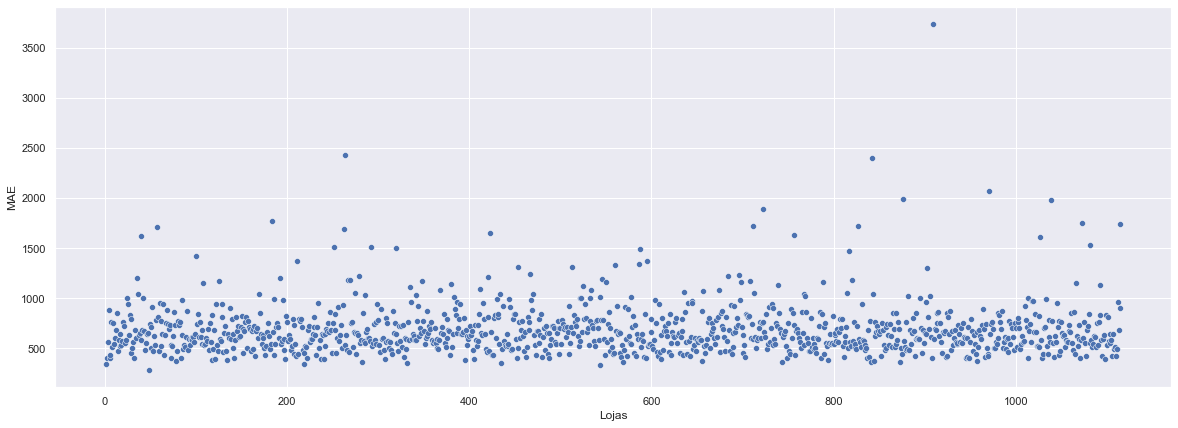

In [102]:
fig = plt.figure(figsize = (20,7))
ax = fig.add_subplot()
sns.scatterplot(x = "Lojas", y = "MAE", data = store_score, ax = ax)
ax.set_xlabel("Lojas")
ax.set_ylabel("MAE")
ax.set_title("Gráfico de Dispeção dos valores de MAE para cada uma das lojas")

Visualmente podemos perceber que o modelo tem um bom desempenho para a grande maioria das lojas, haja vista que a distribuição dos valores de MAE está em torno de 600.

Abaixo vamos comparar os valores de receita reais que as lojas faturaram durante as 6 semanas e os valores previstos pelo nosso modelo

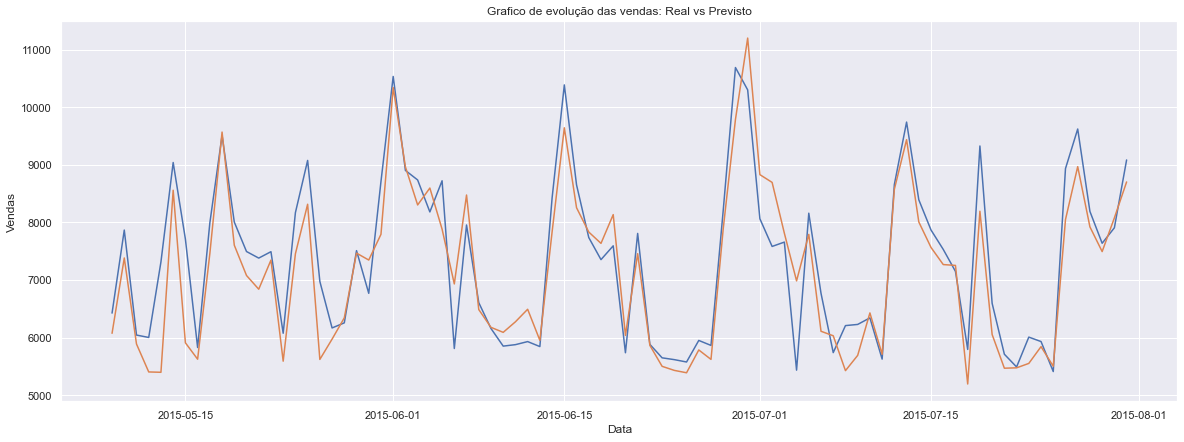

In [119]:
time_df = df_test[["date_year", "date_month", "date_day"]]
time_df.columns = ["year", "month", "day"]
df_test["date"] = pd.to_datetime(time_df)

fig = plt.figure(figsize = (20,7))
ax = fig.add_subplot()
sns.lineplot(x = "date", y = "sales", data = df_test, ax = ax, ci = None)
sns.lineplot(x = "date", y = "predictions", data = df_test, ax = ax, ci = None)
ax.set_xlabel("Data")
ax.set_ylabel("Vendas")
ax.set_title("Grafico de evolução das vendas: Real vs Previsto")
plt.show()